In [29]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import shapely.wkt

In [3]:
df = pd.read_csv('../Data/bikes_station_location.csv')
df.loc[0]

Station #                                       1000
Station Name                Liberty Ave & Stanwix St
NumRacks                                          16
Latitude                                     40.4413
Longitude                                   -80.0047
coordinates     POINT (-80.00467900000001 40.441326)
Name: 0, dtype: object

In [30]:
df = df.rename(columns={"Station Name": "Station_Name"})
df["tractce10"] = 0

for row in range(len(df)):
    df.at[row,"coordinates"] = shapely.wkt.loads(df.loc[row]["coordinates"])

### Location of Bike Stations
Size of each circle for the bike station location represents the number of bike racks at that station

In [31]:
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Station_Name", size="NumRacks",
                  color_continuous_scale=px.colors.diverging.Picnic, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

# Annotating

In [13]:
#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
cenTract.head(1)

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,tractce10_,cnt_tractc,sum_lowmod,sum_lowm_1,lowmodperc,lowmodpe_1,cdbg2018,Shape__Are,Shape__Len,geometry
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,040500,2,2775,2985,92.964824,92.96,Yes,5.079492e+06,10442.03645,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."


In [32]:
#for every point (bike station), check if if it exists in that polygon (census tract)
for row in range(len(df)):
    for tract in range(len(cenTract)):
        if df.loc[row]["coordinates"].within(cenTract.loc[tract]["geometry"]):
            df.at[row,"tractce10"] = cenTract.loc[tract]["tractce10"] 

### Plot by census tract

In [37]:
df['tractce10'] = df.tractce10.astype(str)
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="tractce10", size="NumRacks",
                color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

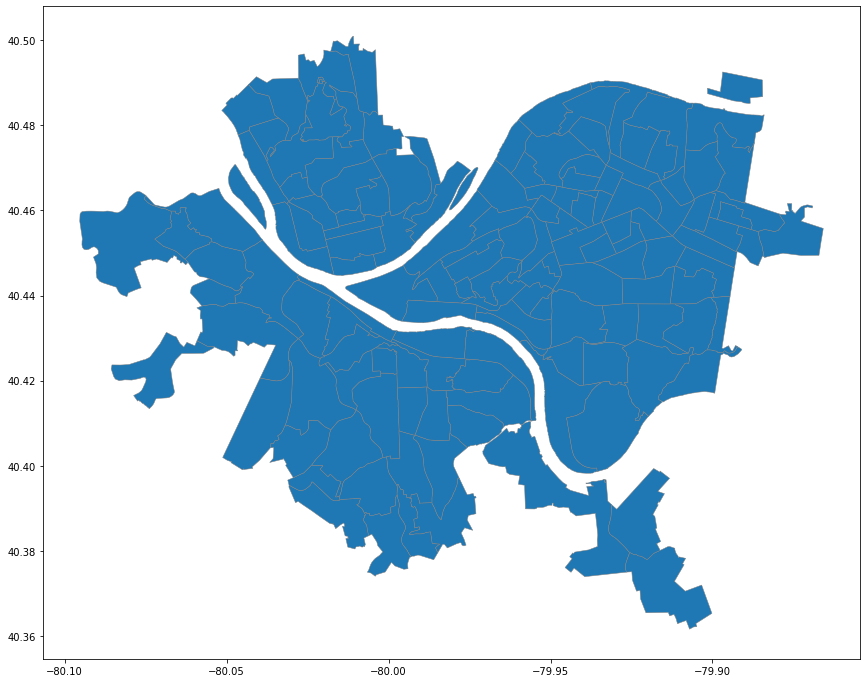

In [14]:
#plot the neighborhood ids on the map
ax = cenTract.plot(figsize = (15, 12), edgecolor = "grey", 
              linewidth = 0.5)